In [1]:
import os
import json
import pprint
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

In [2]:
seed = 42
path = "data/train/"
diags = [x for x in os.listdir(path) if x.startswith("dialogues_pt")]
diags

['dialogues_pt_015.json',
 'dialogues_pt_005.json',
 'dialogues_pt_013.json',
 'dialogues_pt_014.json',
 'dialogues_pt_017.json',
 'dialogues_pt_003.json',
 'dialogues_pt_008.json',
 'dialogues_pt_012.json',
 'dialogues_pt_006.json',
 'dialogues_pt_007.json',
 'dialogues_pt_002.json',
 'dialogues_pt_004.json',
 'dialogues_pt_010.json',
 'dialogues_pt_011.json',
 'dialogues_pt_009.json',
 'dialogues_pt_001.json',
 'dialogues_pt_016.json']

In [3]:
X, y = [], []
for f in diags:
    with open(os.path.join(path,f), 'r') as file:
        data = json.load(file)
    for dialog in data:
        y.append(dialog['services'])
        sp = []
        for turn in dialog['turns']:
            sp.append(turn['utterance_pt'])
        X.append(' '.join(sp))

In [4]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=.25, random_state=seed)

In [5]:
with open("stopwords.txt") as f:
    stopw = f.read().split()
cvec = TfidfVectorizer(max_features=5000, max_df=0.99, min_df=10, stop_words=stopw)
xtrain_vec = cvec.fit_transform(xtrain)

In [6]:
tsne = TSNE(random_state=seed)
xtrain_tsne = tsne.fit_transform(xtrain_vec)
utterances = ['restaurant', 'taxi', 'hotel', 'train', 'attraction']
y_pseudo = [[1 if ut in y else 0 for y in ytrain] for ut in utterances]

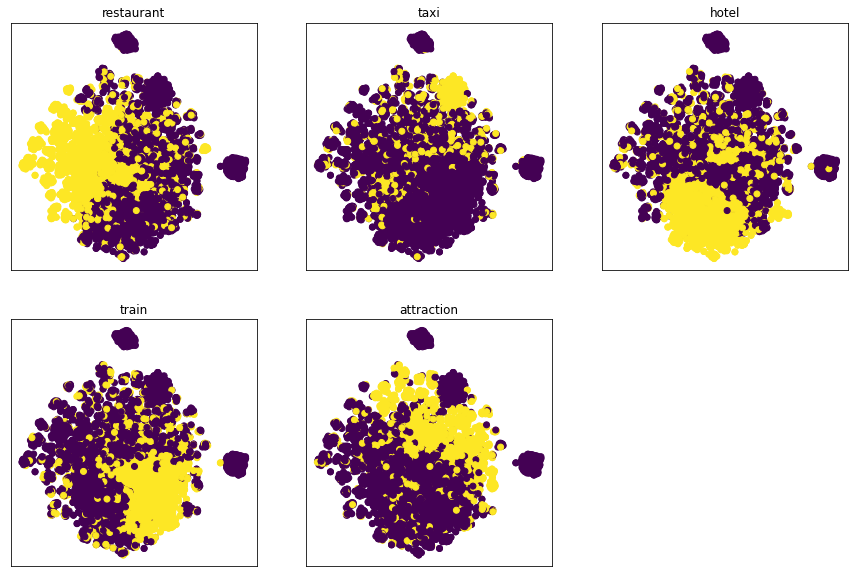

In [7]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharex=True)
axes = axes.flatten()
for i in range(6):
    if i == 5:
        axes[i].axis('off')
    else:
        axes[i].set_title(utterances[i])
        axes[i].scatter(xtrain_tsne[:,0], xtrain_tsne[:,1], c=y_pseudo[i]);
        axes[i].set_xticks([])
        axes[i].set_yticks([])

In [15]:
lda = LatentDirichletAllocation(n_components=5, random_state=seed)
topics = lda.fit_transform(xtrain_vec)

In [16]:
df = pd.DataFrame(topics)
df['y'] = ytrain

In [17]:
sample = df.sample(20)
sample.style.background_gradient(cmap='Reds', axis=1)\
      .format({x:"{:0.3f}" for x in range(10)})

,0,1,2,3,4,y
514,0.045,0.045,0.820,0.046,0.045,[]
1727,0.023,0.023,0.908,0.023,0.023,"['attraction', 'train']"
3515,0.027,0.026,0.894,0.029,0.025,"['attraction', 'train']"
634,0.599,0.023,0.334,0.022,0.022,"['restaurant', 'train']"
4471,0.031,0.031,0.031,0.569,0.338,['restaurant']
2176,0.049,0.049,0.804,0.049,0.049,['train']
350,0.025,0.024,0.878,0.024,0.049,"['attraction', 'train']"
3044,0.036,0.035,0.858,0.036,0.035,['hospital']
1762,0.042,0.042,0.042,0.775,0.100,['restaurant']
5285,0.026,0.026,0.898,0.026,0.025,"['attraction', 'train']"


In [20]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(1, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

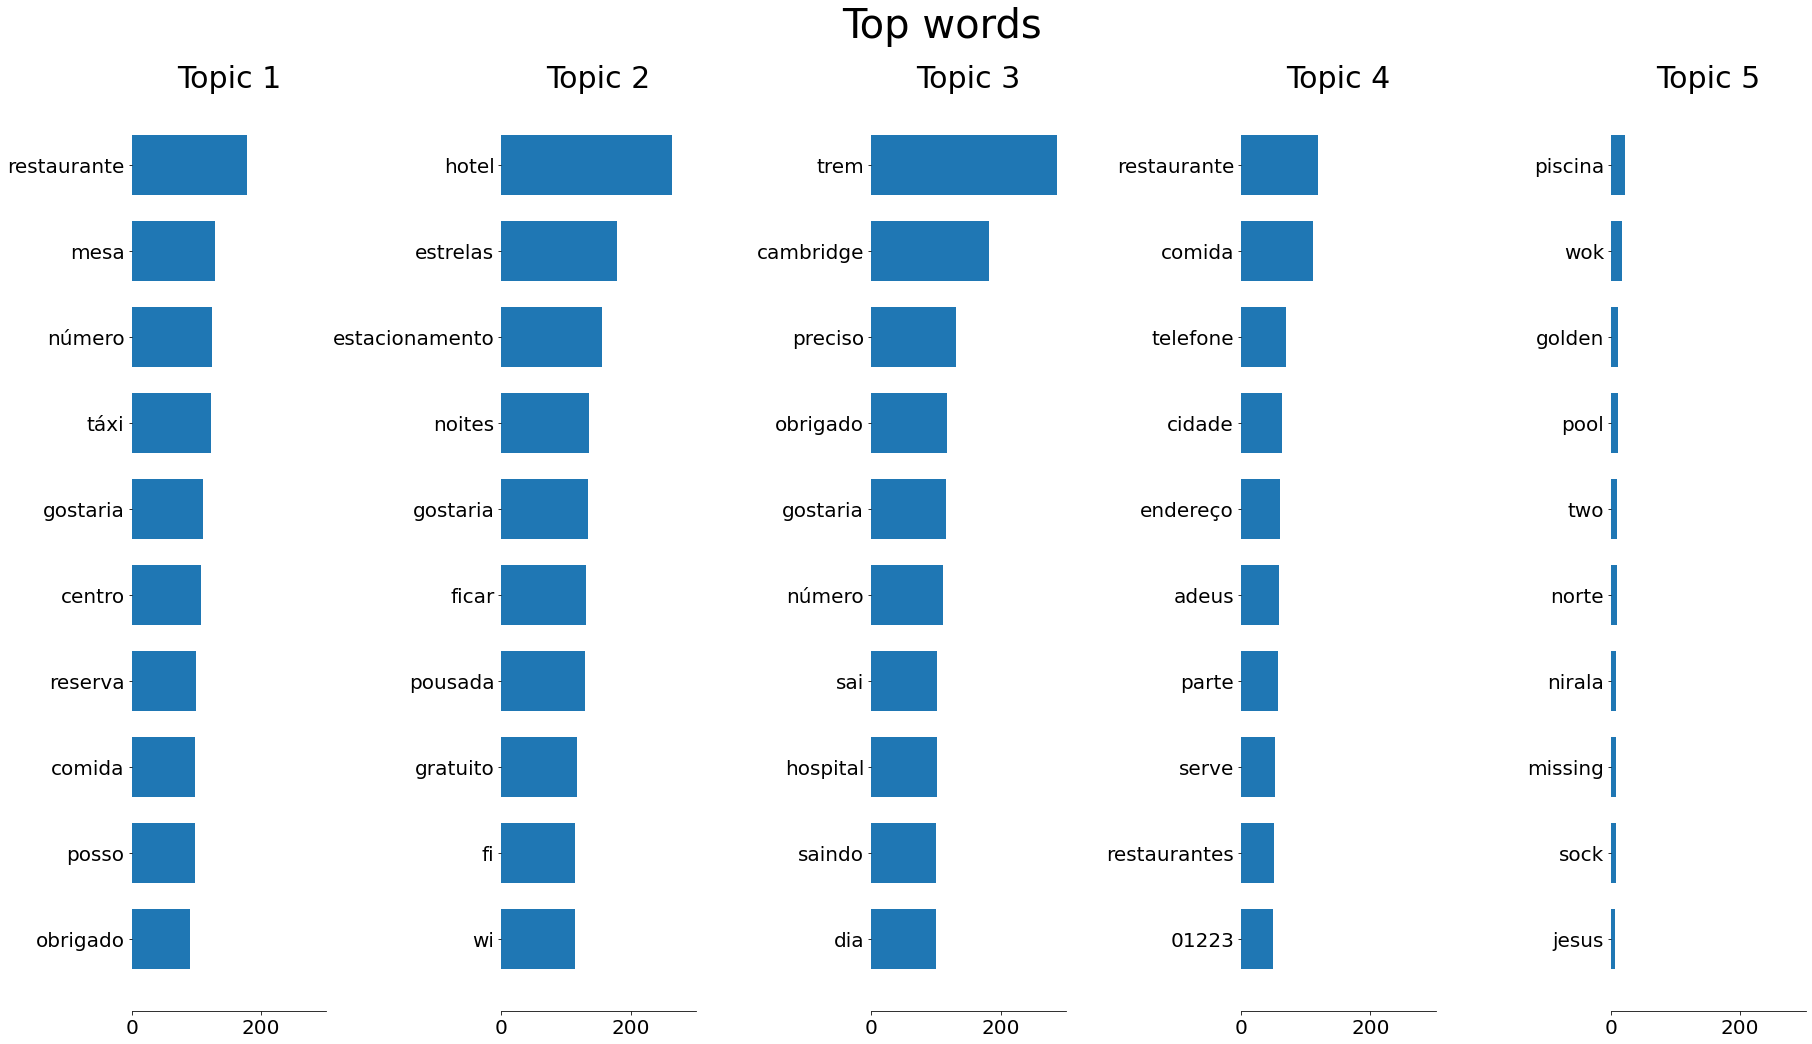

In [21]:
plot_top_words(lda, cvec.get_feature_names(), 10, "Top words")